This notebook explores my first pass of SourceTracker results.

An important note that I did not do anything to control for different _patients_ here: so it's possible that the sourcetracking results are confounded with the patient.

One way to check this will be to see if the patients whose BAL are assigned high gastric are just the patients who have a gastric sample. 

In [23]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import fisher_exact, ranksums, chi2_contingency


In [24]:
fst = '../../data/analysis/sourcetracker/mixing_proportions.txt'
fst_std = '../../data/analysis/sourcetracker/mixing_proportions_stds.txt'
df = pd.read_csv(fst, sep='\t')
stds = pd.read_csv(fst_std, sep='\t')

In [25]:
df.head()

,SampleID,gastric_fluid,throat_swab,Unknown
0,04-113-7B,0.0030,0.0006,0.9964
1,04-086-2B,0.0028,0.0003,0.9969
2,12-160-1B,0.6845,0.0654,0.2501
3,04-116-2B,0.8574,0.0366,0.1060
4,04-208-1B,0.8398,0.1254,0.0348


In [26]:
stds.head()

,SampleID,gastric_fluid,throat_swab,Unknown
0,04-113-7B,0.001732,0.000490,0.001562
1,04-086-2B,0.001470,0.000458,0.001640
2,12-160-1B,0.018112,0.014016,0.009638
3,04-116-2B,0.013048,0.008102,0.012402
4,04-208-1B,0.022864,0.023665,0.002441


In [27]:
tidydf = pd.melt(df, id_vars='SampleID', var_name='env', value_name='proportion')
tidydf.head()

,SampleID,env,proportion
0,04-113-7B,gastric_fluid,0.0030
1,04-086-2B,gastric_fluid,0.0028
2,12-160-1B,gastric_fluid,0.6845
3,04-116-2B,gastric_fluid,0.8574
4,04-208-1B,gastric_fluid,0.8398


In [28]:
# Add in metadata
fmeta = '../../data/clean/rosen.metadata.clean'
meta = pd.read_csv(fmeta, sep='\t', index_col=0)
meta.head()

,"If Yes, specify the symptom score","If yes, please indicate level",% time pH<4,% time pH<4:,A1. Subject ID number:,A2. Subject initials:,A3. What Cohort is the subject enrolled into?,A4. Aim(s) enrolled in?,A5. Date of initial/baseline visit/procedure (MM/DD/YYYY):,A5a. Date filled out(MM/DD/YYYY):,...,STUDYID,STUDY,AIM,SOURCE,PHMII,ACIDSUP,DATE,ppi_consolidated,mbs_consolidated,total_reads
01-112-7GI,NaN,NaN,NaN,NaN,01-112-7,DM,GERD,Aim 1,2014-04-14,2014-04-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,271980
01-112-7RI,NaN,NaN,NaN,NaN,01-112-7,DM,GERD,Aim 1,2014-04-14,2014-04-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,244891
01-112-7TI,NaN,NaN,NaN,NaN,01-112-7,DM,GERD,Aim 1,2014-04-14,2014-04-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41988
01-164-7GI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89821
01-164-7RI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72671


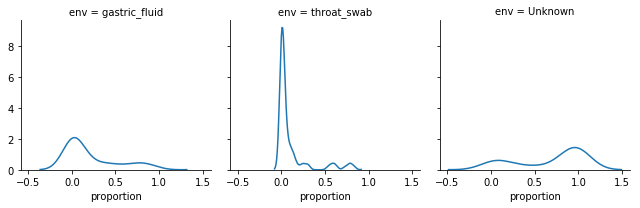

In [29]:
g = sns.FacetGrid(data=tidydf, col='env')
g.map(sns.kdeplot, 'proportion')

In [30]:
keep_smpls = meta.index.tolist()

In [31]:
df = df.query('SampleID == @keep_smpls')

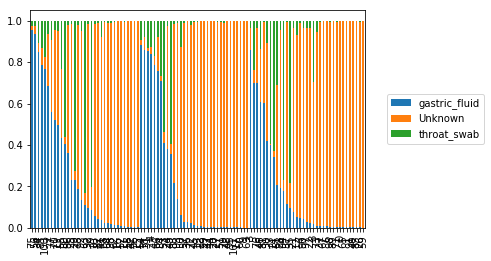

In [32]:
df['mbs_consolidated'] = df['SampleID'].apply(lambda x: meta.loc[x, 'mbs_consolidated'])
df = df.fillna('nan')
df = df.sort_values(by=['mbs_consolidated', 'gastric_fluid', 'Unknown'], ascending=[True, False, False])
df[['gastric_fluid', 'Unknown', 'throat_swab']].plot(kind='bar', stacked=True).legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

In [33]:
# Again, but this time with stderrs
# Re-order so they match the new dataframe order
stds = stds.loc[df.index]
stds.head()

,SampleID,gastric_fluid,throat_swab,Unknown
75,04-303-7B,0.006063,0.006750,0.002691
56,04-291-3B,0.005235,0.006074,0.002844
34,04-182-6B,0.019614,0.019463,0.001833
85,04-139-5B,0.021031,0.022204,0.005186
100,04-157-4B,0.031034,0.032236,0.006357


In [34]:
df.head()

,SampleID,gastric_fluid,throat_swab,Unknown,mbs_consolidated
75,04-303-7B,0.9542,0.0262,0.0196,Aspiration/Penetration
56,04-291-3B,0.9350,0.0249,0.0401,Aspiration/Penetration
34,04-182-6B,0.8479,0.1083,0.0438,Aspiration/Penetration
85,04-139-5B,0.7839,0.1320,0.0841,Aspiration/Penetration
100,04-157-4B,0.7649,0.1758,0.0593,Aspiration/Penetration


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a17a36b10>,
      dtype=object)

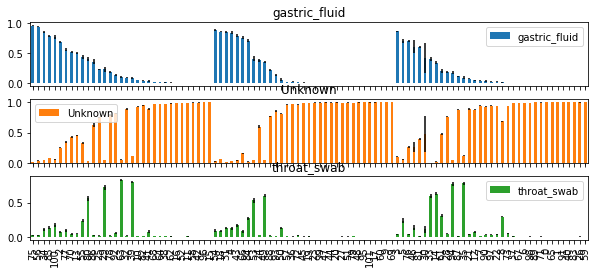

In [35]:
df[['gastric_fluid', 'Unknown', 'throat_swab']].plot(
    kind='bar',
    subplots=True,
    yerr=stds,
    figsize=(10, 4))


Okay, so it looks like the stderr's are actually pretty tight. Only a few samples with high variance.

# How many samples classified as each type?

In [39]:
tidydf.query('proportion > 0.5')['env'].value_counts()

Unknown          68
gastric_fluid    20
throat_swab      10
Name: env, dtype: int64

In [40]:
# Merge metadata into sourcetracker data
tidydf = pd.merge(
    tidydf, meta[['subject_id', 'site', 'mbs_consolidated']], 
    left_on='SampleID', right_index=True)
tidydf.head(10)

,SampleID,env,proportion,subject_id,site,mbs_consolidated
0,04-113-7B,gastric_fluid,0.0030,04-113-7,bal,NaN
102,04-113-7B,throat_swab,0.0006,04-113-7,bal,NaN
204,04-113-7B,Unknown,0.9964,04-113-7,bal,NaN
1,04-086-2B,gastric_fluid,0.0028,04-086-2,bal,NaN
103,04-086-2B,throat_swab,0.0003,04-086-2,bal,NaN
205,04-086-2B,Unknown,0.9969,04-086-2,bal,NaN
2,12-160-1B,gastric_fluid,0.6845,12-160-1,bal,Aspiration/Penetration
104,12-160-1B,throat_swab,0.0654,12-160-1,bal,Aspiration/Penetration
206,12-160-1B,Unknown,0.2501,12-160-1,bal,Aspiration/Penetration
3,04-116-2B,gastric_fluid,0.8574,04-116-2,bal,NaN


In [41]:
tidydf.head()

,SampleID,env,proportion,subject_id,site,mbs_consolidated
0,04-113-7B,gastric_fluid,0.0030,04-113-7,bal,NaN
102,04-113-7B,throat_swab,0.0006,04-113-7,bal,NaN
204,04-113-7B,Unknown,0.9964,04-113-7,bal,NaN
1,04-086-2B,gastric_fluid,0.0028,04-086-2,bal,NaN
103,04-086-2B,throat_swab,0.0003,04-086-2,bal,NaN


In [42]:
tidydf.query('proportion > 0.5').groupby(['env', 'mbs_consolidated']).size()

env            mbs_consolidated      
Unknown        Aspiration/Penetration    19
               Normal                    24
gastric_fluid  Aspiration/Penetration     8
               Normal                     7
throat_swab    Aspiration/Penetration     4
               Normal                     2
dtype: int64

In [43]:
asp_vs_classified_env = (tidydf
     .fillna('nan')
     .query('proportion > 0.5')
     .groupby(['env', 'mbs_consolidated'])
     .size()
     .reset_index()
     .pivot(index='env', columns='mbs_consolidated')
)

print(chi2_contingency(asp_vs_classified_env.values))
asp_vs_classified_env

(2.17334004464481, 0.7039129945573851, 4, array([[21.41237113, 22.79381443, 22.79381443],
       [ 6.39175258,  6.80412371,  6.80412371],
       [ 3.19587629,  3.40206186,  3.40206186]]))


0           
mbs_consolidated Aspiration/Penetration Normal nan
env                                               
Unknown                              19     24  24
gastric_fluid                         8      7   5
throat_swab                           4      2   4

Oh wait, I should actually assign each sample to a class based on which one is maximal (not just which one is above 0.5).

In [44]:
df['max_env_source'] = df.apply(lambda row: row[['gastric_fluid', 'throat_swab', 'Unknown']].astype(float).idxmax(), axis=1)
df.head()

,SampleID,gastric_fluid,throat_swab,Unknown,mbs_consolidated,max_env_source
75,04-303-7B,0.9542,0.0262,0.0196,Aspiration/Penetration,gastric_fluid
56,04-291-3B,0.9350,0.0249,0.0401,Aspiration/Penetration,gastric_fluid
34,04-182-6B,0.8479,0.1083,0.0438,Aspiration/Penetration,gastric_fluid
85,04-139-5B,0.7839,0.1320,0.0841,Aspiration/Penetration,gastric_fluid
100,04-157-4B,0.7649,0.1758,0.0593,Aspiration/Penetration,gastric_fluid


In [45]:
asp_vs_max_env = (df.groupby(['max_env_source', 'mbs_consolidated'])
     .size()
     .reset_index()
     .pivot(index='max_env_source', columns='mbs_consolidated')
)

print(chi2_contingency(asp_vs_max_env.values))
asp_vs_max_env

(3.5800046769216722, 0.4658181745020302, 4, array([[22.54455446, 22.54455446, 23.91089109],
       [ 7.18811881,  7.18811881,  7.62376238],
       [ 3.26732673,  3.26732673,  3.46534653]]))


0           
mbs_consolidated Aspiration/Penetration Normal nan
max_env_source                                    
Unknown                              19     24  26
gastric_fluid                        10      7   5
throat_swab                           4      2   4

# Check confounding with gastric fluid sampling

Do samples which are predicted to be gastric fluid tend to be ones from patients who have a gastric fluid sample?

In [46]:
# Grab subjects whose BAL samples are more than 50% "gastric fluid"
pred_gastric_subjs = (
    tidydf
        .query('env == "gastric_fluid"')
        .query('proportion > 0.5')
        ['subject_id'].tolist()
)

print(len(pred_gastric_subjs))

# See which sites these patients have sequenced
meta\
    .query('subject_id == @pred_gastric_subjs')\
    .query('site == "gastric_fluid"')\
    .shape

20


(17, 958)

So 17 out of the 20 patients whose BAL was predicted to be predominantly "gastric_fluid" also have a gastric fluid sample. Let's see how this shakes out for the BAL samples which _weren't_ predicated to be gastric.

In [47]:
# Grab subjects whose BAL samples are more than 50% "gastric fluid"
pred_not_gastric_subjs = (
    tidydf
        .query('env == "gastric_fluid"')
        .query('proportion <= 0.5')
        ['subject_id'].tolist()
)

print(len(pred_not_gastric_subjs))

# See which sites these patients have sequenced
meta\
    .query('subject_id == @pred_not_gastric_subjs')\
    .query('site == "gastric_fluid"')\
    .shape

81


(71, 958)

So 72 of the 82 subjects whose BAL was _not_ predicted to be gastric fluid had a gastric fluid sample sequenced.

In [48]:
fisher = pd.DataFrame(data=[[82-72, 72], [20-17, 17]],
                      columns=["don't have gastric", "do have gastric"],
                      index=['not predicted gastric', 'predicted gastric'])
fisher

,don't have gastric,do have gastric
not predicted gastric,10,72
predicted gastric,3,17


In [49]:
fisher_exact(fisher)

(0.7870370370370371, 0.7155476742710635)

Okay, so that's not confounded. Good, I guess?

# See if it's interesting, I guess?

Look at relationship with aspiration...

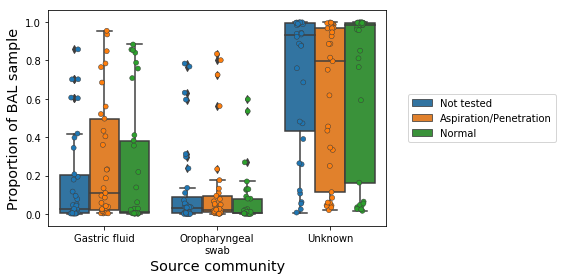

In [63]:
tidydf['mbs_consolidated'] = tidydf['mbs_consolidated'].fillna('Not tested')

fig, ax = plt.subplots(figsize=(8, 4))

sns.boxplot(data=tidydf, x='env', y='proportion', hue='mbs_consolidated')
sns.stripplot(data=tidydf, x='env', y='proportion', hue='mbs_consolidated', 
              dodge=True, linewidth=0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:3], labels[:3], loc='center left', bbox_to_anchor=(1.05, 0.5))

ax.set_ylabel('Proportion of BAL sample', fontsize='x-large')
ax.set_xlabel('Source community', fontsize='x-large')
ax.set_xticklabels(['Gastric fluid', 'Oropharyngeal\nswab', 'Unknown'])

fig.tight_layout()
fig.savefig('../../final/figures/reviewer.sourcetracker_proportions.png')

In [51]:
# Check sample sizes
for site, subdf in tidydf.groupby('env'):
    print(subdf.groupby(['mbs_consolidated']).size())

mbs_consolidated
Aspiration/Penetration    33
Normal                    33
dtype: int64
mbs_consolidated
Aspiration/Penetration    33
Normal                    33
dtype: int64
mbs_consolidated
Aspiration/Penetration    33
Normal                    33
dtype: int64


Oh right, these are just plotting the BAL samples. Yes, 33 of each group is correct.

In [52]:
asp = 'Aspiration/Penetration'
nml = 'Normal'
for site, subdf in tidydf.groupby('env'):
    print(site)
    x = subdf.query('mbs_consolidated == @asp')['proportion'].values
    y = subdf.query('mbs_consolidated == @nml')['proportion'].values
    print(ranksums(x, y))

Unknown
RanksumsResult(statistic=-1.6735927794463104, pvalue=0.09421065855744282)
gastric_fluid
RanksumsResult(statistic=1.8018374368751464, pvalue=0.07157098578495692)
throat_swab
RanksumsResult(statistic=1.8338986012323555, pvalue=0.06666904726002462)


Ehh they're all marginally significant but not really. That said I'm not sure I trust the actual proportions or that they mean anything in particular? If we do the contingency table (above), it's not significant.